### With stopwords

# CMSC 197 - Special Topics (Machine Learning)
## MP3: Naive Bayes Spam Filter
Submitted by: Kristina V. Celis 

Github Link: <https://github.com/tinapayy/CMSC-197>

In [2]:
# IMPORTS
### standard libraries ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### preprocessing ###
import os
import re
from collections import Counter
import email

### performance evaluation plot ###
from sklearn.metrics import confusion_matrix
import seaborn as sns


## Preprocessing 

We will preprocess the email data by cleaning the text, removing non-alphabetic characters, stop words, and creating a dictionary of the 10,000 most frequent words. We will also then split the dataset into training and testing sets ( 3 groups: ham training set, spam training set, and testing set)


In [6]:
# Initialize main dataframe

main_df = pd.DataFrame(columns=["folder", "file", "email_message", "category"])
main_df

,folder,file,email_message,category


In [8]:
# Temporary df for storing labels
labels_path = "trec06p-cs280/labels"

labels_df = pd.read_csv(labels_path, sep=" ", header=None)
labels_df.columns = ["category", "file_path"]

# Change ham/spam to 0/1
labels_df["category"] = labels_df["category"].apply(lambda x: 0 if x == "ham" else 1)
# Remove "../data/" from file_path
labels_df["file_path"] = labels_df["file_path"].apply(lambda x: x.replace("../data/", ""))

# Show df
labels_df

,category,file_path
0,0,000/000
1,1,000/001
2,1,000/002
3,0,000/003
4,1,000/004
...,...,...
37817,1,126/017
37818,1,126/018
37819,1,126/019
37820,1,126/020


In [10]:
folder_path = "trec06p-cs280/data/"
folders = os.listdir(folder_path)
folders

['.DS_Store',
 '000',
 '001',
 '002',
 '003',
 '004',
 '005',
 '006',
 '007',
 '008',
 '009',
 '010',
 '011',
 '012',
 '013',
 '014',
 '015',
 '016',
 '017',
 '018',
 '019',
 '020',
 '021',
 '022',
 '023',
 '024',
 '025',
 '026',
 '027',
 '028',
 '029',
 '030',
 '031',
 '032',
 '033',
 '034',
 '035',
 '036',
 '037',
 '038',
 '039',
 '040',
 '041',
 '042',
 '043',
 '044',
 '045',
 '046',
 '047',
 '048',
 '049',
 '050',
 '051',
 '052',
 '053',
 '054',
 '055',
 '056',
 '057',
 '058',
 '059',
 '060',
 '061',
 '062',
 '063',
 '064',
 '065',
 '066',
 '067',
 '068',
 '069',
 '070',
 '071',
 '072',
 '073',
 '074',
 '075',
 '076',
 '077',
 '078',
 '079',
 '080',
 '081',
 '082',
 '083',
 '084',
 '085',
 '086',
 '087',
 '088',
 '089',
 '090',
 '091',
 '092',
 '093',
 '094',
 '095',
 '096',
 '097',
 '098',
 '099',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '

In [12]:
# Useless info to be removed from the email
stop_words = []
punctuations = r"!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"
numbers = "0123456789"
html_tags = re.compile(r"<.*?>")  # remove HTML tags
esc_chars = re.compile(r"[a-z][a-z][0-9]+")  # remove escape characters

# Load the stop words
with open("stop_words.txt", "r") as f:
    stop_word = f.read().splitlines()
    stop_words = [word for word in stop_word]

In [16]:
def clean_email(message):
    # Convert to lowercase
    message = message.lower()
    # Remove HTML tags
    message = re.sub(html_tags, '', message)
    # Remove symbols (punctuations)
    message = message.translate(str.maketrans('', '', punctuations))
    # Remove numbers
    message = message.translate(str.maketrans('', '', numbers))
    # Remove escape characters
    message = re.sub(esc_chars, '', message)
    # Remove non-alphabetic characters
    message = re.sub(r'[^a-zA-Z\s]', '', message)

    words = message.split()
    
    # Rejoin words into a cleaned message
    message = " ".join(words)
    
    return message

In [18]:
# Function to get message from parsed email
def get_message(parsed):
    message = ""
    # If email has attachments, etc.,
    if parsed.is_multipart():
        # Iterate over parts of the email
        for part in parsed.walk():
            # If the content type of the part is text/plain,
            if part.get_content_type() == 'text/plain':
                # Get message
                message = part.get_payload()
                break
    # else, just get the message
    else:
        message = parsed.get_payload()
    return message

Preprocessed the emails in a standard charset (ISO-8859-1), and cleaned the emails so that all data will be preserved regardless of encoding.

In [20]:
# Get all folders except hidden/system files
folders = [folder for folder in os.listdir(folder_path) if not folder.startswith('.')]

# Loop through the filtered folders
for folder in folders:
    # Get all files in the folder, excluding hidden/system files like .DS_Store
    files = [file for file in os.listdir(f"{folder_path}/{folder}") if not file.startswith('.')]
    
    for file in files:
        # Process each email file
        with open(f"{folder_path}/{folder}/{file}", "r", encoding="ISO-8859-1") as e_mail:
             # Read email file
            read_email = e_mail.read()
            # Parse email
            parsed_email = email.message_from_string(read_email)
            # Get message
            message = get_message(parsed_email)
            # Remove useless information
            message_w_stopwords = clean_email(message)
            # Get the category of the email based on the labels df
            category_label = labels_df[labels_df ["file_path"] == f"{folder}/{file}"]["category"].values[0]
            # Concatenate the data to the df_main
            main_df = pd.concat([main_df, pd.DataFrame([[folder, file, message_w_stopwords, category_label]], columns=["folder", "file", "email_message", "category"])], ignore_index=True)
# Show the main dataframe
main_df

,folder,file,email_message,category
0,000,000,the mailing list i queried about a few weeks a...,0
1,000,001,luxury watches buy your own rolex for only rol...,1
2,000,002,academic qualifications available from prestig...,1
3,000,003,greetings all this is to verify your subscript...,0
4,000,004,try chauncey may conferred the luscious not co...,1
...,...,...,...,...
37817,126,017,great news expec ted infinex ventures inc infx...,1
37818,126,018,the oil sector is going crazy this is our week...,1
37819,126,019,httpvdtobjdocscaninfo suffering from pain depr...,1
37820,126,020,u n i v e r s i t y d i p l o m a s do you wan...,1


Create a folder and store the preprocessed files as a .csv

In [22]:
if not os.path.exists('preprocessed_files'):
    os.makedirs('preprocessed_files')

# Save main_df as preprocessed_emails_w_sw.csv
main_df.to_csv("preprocessed_files/preprocessed_emails_w_sw.csv", index = False)

# Reset the main df to avoid memory overload
main_df.drop(main_df.index, inplace = True)
main_df = pd.DataFrame(columns = ["folder", "file", "email_message", "category"])
main_df

,folder,file,email_message,category


In [24]:
# Load the preprocessed dataset
df_main = pd.read_csv("./preprocessed_files/preprocessed_emails_w_sw.csv")

# Split the dataset into training and testing sets
train_df = df_main[df_main['folder'] <= 70] #Folders 0-70: Train Set
test_df = df_main[df_main['folder'] > 70] #Folders 71-126: Test Set

# Split training to spam and ham
train_spam_df = train_df[train_df['category'] == 1]
train_ham_df = train_df[train_df['category'] == 0]

In [26]:
df_main

,folder,file,email_message,category
0,0,0,the mailing list i queried about a few weeks a...,0
1,0,1,luxury watches buy your own rolex for only rol...,1
2,0,2,academic qualifications available from prestig...,1
3,0,3,greetings all this is to verify your subscript...,0
4,0,4,try chauncey may conferred the luscious not co...,1
...,...,...,...,...
37817,126,17,great news expec ted infinex ventures inc infx...,1
37818,126,18,the oil sector is going crazy this is our week...,1
37819,126,19,httpvdtobjdocscaninfo suffering from pain depr...,1
37820,126,20,u n i v e r s i t y d i p l o m a s do you wan...,1


In [28]:
train_spam_df

,folder,file,email_message,category
1,0,1,luxury watches buy your own rolex for only rol...,1
2,0,2,academic qualifications available from prestig...,1
4,0,4,try chauncey may conferred the luscious not co...,1
7,0,7,from nbc today show its the look everyone want...,1
8,0,8,the oil sector is going crazy this is our week...,1
...,...,...,...,...
21294,70,294,txtadd,1
21295,70,295,btijclnab binpqnejgmb httpgethighbizez bldb xi...,1
21296,70,296,special offer adobe video collection adobe pre...,1
21297,70,297,doctype html public wcdtd html transitionalen ...,1


In [30]:
train_ham_df

,folder,file,email_message,category
0,0,0,the mailing list i queried about a few weeks a...,0
3,0,3,greetings all this is to verify your subscript...,0
5,0,5,its quiet too quiet well how about a straw pol...,0
6,0,6,its working here i have departed almost totall...,0
10,0,10,greetings all this is a mass acknowledgement t...,0
...,...,...,...,...
21270,70,270,here is an equation that generate all prime nu...,0
21271,70,271,here is an equation that generate all prime nu...,0
21288,70,288,dear dmdx users i would like guidance in gener...,0
21293,70,293,hi i built up a handyboard and most of it work...,0


In [32]:
test_df

,folder,file,email_message,category
21300,71,0,where we can hesitantly derive perverse satisf...,1
21301,71,1,there are several things you can use to perfor...,0
21302,71,2,best offer of the month viggra ci ialis vaiium...,1
21303,71,3,de i ar home o h wne n r your cr v ed b it doe...,1
21304,71,4,special offer adobe video collection adobe pre...,1
...,...,...,...,...
37817,126,17,great news expec ted infinex ventures inc infx...,1
37818,126,18,the oil sector is going crazy this is our week...,1
37819,126,19,httpvdtobjdocscaninfo suffering from pain depr...,1
37820,126,20,u n i v e r s i t y d i p l o m a s do you wan...,1


To limit the cardinality 
of the dictionary, we can extract only the 10000 most common words

In [34]:
# Initialize a Counter object to keep track of word frequencies
word_counter = Counter()

# Iterate over the df and update the word counts
for email_message in train_df['email_message'].astype(str):
    word_counter.update(email_message.split())

sorted_words = dict(sorted(word_counter.items(), key=lambda item: item[1], reverse=True))

# Get the top 10000 most common words
top_10000_words = dict(word_counter.most_common(10000))

# Create a list of the top 10000 words for future use
top_10000_words_list = list(top_10000_words.keys())

top_10000_words

{'the': 130146,
 'to': 80676,
 'a': 68496,
 'and': 62161,
 'of': 56633,
 'i': 42876,
 'in': 39912,
 'is': 35393,
 'for': 30239,
 'you': 29575,
 'that': 24226,
 'it': 22360,
 'on': 21953,
 'this': 21309,
 'with': 19930,
 'be': 18087,
 'from': 17288,
 'bb': 16752,
 'have': 15512,
 'are': 14886,
 'as': 14108,
 'your': 13666,
 'at': 13123,
 'or': 12792,
 'by': 12287,
 'not': 12197,
 'will': 11325,
 'we': 11185,
 'if': 10802,
 'but': 10248,
 'can': 10145,
 'an': 8927,
 'all': 8461,
 'has': 7906,
 'our': 7675,
 'my': 7462,
 'was': 7157,
 'one': 7140,
 'any': 6664,
 'its': 6648,
 'v': 6588,
 'more': 6581,
 'would': 6417,
 'me': 6359,
 'do': 6066,
 'get': 6039,
 'there': 5958,
 'about': 5911,
 'l': 5857,
 'some': 5737,
 'c': 5582,
 'what': 5486,
 'so': 5486,
 'e': 5465,
 'no': 5370,
 'x': 5243,
 'like': 5178,
 'board': 5169,
 'they': 5166,
 'up': 5139,
 'out': 4996,
 'which': 4970,
 'now': 4934,
 'may': 4915,
 'use': 4902,
 'when': 4822,
 'company': 4523,
 'price': 4497,
 'am': 4446,
 'r': 443

In [36]:
def filter_words_by_frequency(word_counts, min_count):
    # Filter the words based on the minimum count (k).
    return {word: count for word, count in word_counts.items() if count > min_count}


## Creating the feature matrices

In [38]:
# Create feature matrix helper function
def create_feature_matrix(df, top_words_list, text_column='email_message'):
    # Create a dictionary for fast word-to-index lookups
    word_to_index = {word: idx for idx, word in enumerate(top_words_list)}
    
    # Initialize the feature matrix with zeros
    feature_matrix = np.zeros((len(df), len(top_words_list)), dtype=np.int32)
    
    # Populate the feature matrix
    for i, email_message in enumerate(df[text_column].astype(str)):
        words = set(email_message.split())  # Convert to set for faster lookups and prevent duplicates
        for word in words:
            if word in word_to_index:  # Check if the word is in the top words
                feature_matrix[i, word_to_index[word]] = 1  # Set the corresponding column to 1

    return feature_matrix

# Create feature matrices for ham and spam emails
ham_train_matrix = create_feature_matrix(train_ham_df, top_10000_words_list)
spam_train_matrix = create_feature_matrix(train_spam_df, top_10000_words_list)

In [40]:
ham_train_matrix

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [42]:
spam_train_matrix

array([[1, 0, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]])

## Computing the Priors

The prior probabilities for spam and ham are computed by the ff formula:

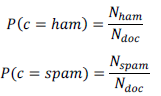

In [44]:
# Num of ham emails in the training set
n_ham = len(train_ham_df)
# Num of spam emails in the training set
n_spam = len(train_spam_df)
# Total number of emails
n_doc = len(train_df)

# Formulas
p_ham = n_ham/n_doc
p_spam = n_spam/n_doc

print(f"P(c = ham) = {p_ham}")
print(f"P(c = spam) = {p_spam}")

P(c = ham) = 0.3531924882629108
P(c = spam) = 0.6468075117370892


## Computing the Likelihood of each word

To avoid zero probabilities for words not present in the training data, we will use Laplace smoothing with a smoothing factor `λ=1`.


In [46]:
lambda_smoothing = 1

# Calculate likelihood for each word given ham/spam
def calculate_likelihoods_with_laplace(matrix, vocabulary_size, lambda_smoothing):
    word_counts = np.sum(matrix, axis=0)
    total_count = np.sum(word_counts)
    likelihoods = (word_counts + lambda_smoothing) / (total_count + lambda_smoothing * vocabulary_size)
    return likelihoods

# Likelihood of each word given spam and ham
likelihood_spam = calculate_likelihoods_with_laplace(spam_train_matrix, len(top_10000_words_list), lambda_smoothing)
likelihood_ham = calculate_likelihoods_with_laplace(ham_train_matrix, len(top_10000_words_list), lambda_smoothing)

# Print the word probabilities for spam and ham
print(f"Spam word probabilities:\n {likelihood_spam}")
print(f"Ham word probabilities: \n {likelihood_ham}")

Spam word probabilities:
 [7.97317765e-03 7.96876608e-03 8.24375395e-03 ... 7.35261680e-06
 2.20578504e-05 2.20578504e-05]
Ham word probabilities: 
 [9.76408108e-03 9.27323731e-03 8.63970641e-03 ... 2.42568140e-05
 9.98809989e-06 8.56122848e-06]


## Classifying the emails

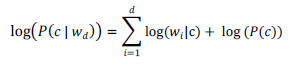

In [50]:
# Classifier Function
def classify_email(email, spam_word_probs, ham_word_probs, p_spam, p_ham):
    # Initialize the log probabilities
    classify_spam = 0
    classify_ham = 0
    
    # Split the email
    email_words = str(email).split()
    
    # Compute the log probability of each
    for word in email_words:
        if word in top_10000_words:
            i = top_10000_words_list.index(word)
            classify_spam += np.log(spam_word_probs[i])
            classify_ham += np.log(ham_word_probs[i])
    
    # Add the log probability of spam and ham
    classify_spam += np.log(p_spam)
    classify_ham += np.log(p_ham)
    
    # Return the class with the highest probability
    return 1 if classify_spam > classify_ham else 0

# Classify all emails in the dataset and store the predicted label (1 = spam, 0 = ham)
train_df.loc[:, 'predicted'] = train_df['email_message'].apply(lambda x: classify_email(x, likelihood_spam, likelihood_ham, p_spam, p_ham))
train_df

,folder,file,email_message,category,predicted
0,0,0,the mailing list i queried about a few weeks a...,0,0
1,0,1,luxury watches buy your own rolex for only rol...,1,1
2,0,2,academic qualifications available from prestig...,1,1
3,0,3,greetings all this is to verify your subscript...,0,0
4,0,4,try chauncey may conferred the luscious not co...,1,0
...,...,...,...,...,...
21295,70,295,btijclnab binpqnejgmb httpgethighbizez bldb xi...,1,1
21296,70,296,special offer adobe video collection adobe pre...,1,1
21297,70,297,doctype html public wcdtd html transitionalen ...,1,1
21298,70,298,i have mounted the isu infrared demodulator on...,0,0


## Testing the Classifier

In [54]:
# Using the test_df, we will classify the test emails
test_df.loc[:, 'predicted'] = test_df['email_message'].apply(lambda x: classify_email(x, likelihood_spam, likelihood_ham, p_spam, p_ham))
test_df

,folder,file,email_message,category,predicted
21300,71,0,where we can hesitantly derive perverse satisf...,1,1
21301,71,1,there are several things you can use to perfor...,0,0
21302,71,2,best offer of the month viggra ci ialis vaiium...,1,1
21303,71,3,de i ar home o h wne n r your cr v ed b it doe...,1,1
21304,71,4,special offer adobe video collection adobe pre...,1,1
...,...,...,...,...,...
37817,126,17,great news expec ted infinex ventures inc infx...,1,1
37818,126,18,the oil sector is going crazy this is our week...,1,1
37819,126,19,httpvdtobjdocscaninfo suffering from pain depr...,1,1
37820,126,20,u n i v e r s i t y d i p l o m a s do you wan...,1,1


## Performance Evaluation

Accuracy: 0.9106645684541823 = 91.07%
Precision: 0.9746437346437347 = 97.46%
Recall: 0.8906151773686574 = 89.06%
F1-Score: 0.9307367433129986 = 93.07%


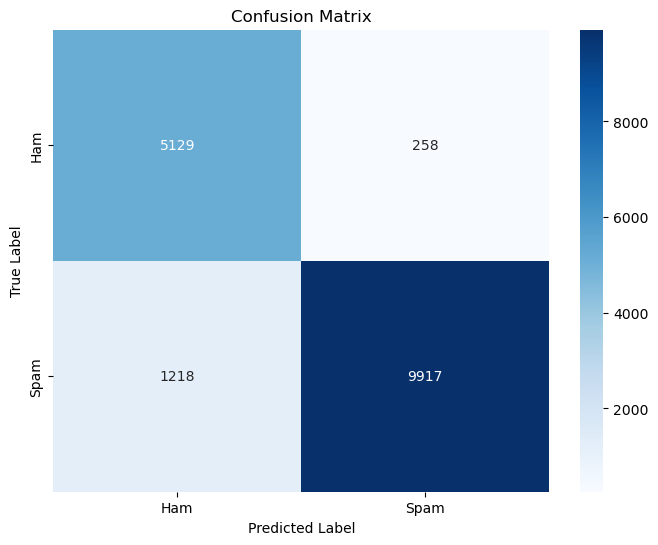

In [70]:
# Define the evaluation function
def evaluate_model(test_df, true_column, predicted_column):
    # Initialize counts for confusion matrix elements
    TP = FP = TN = FN = 0

    # Iterate over the test set and predicted labels
    for index, row in test_df.iterrows():
        true_label = int(row[true_column])  # Assuming 1 for spam and 0 for ham
        predicted_label = int(row[predicted_column])

        if predicted_label == 1 and true_label == 1:
            TP += 1  # True Positive (correctly classified spam emails)
        elif predicted_label == 1 and true_label == 0:
            FP += 1  # False Positive (misclassified ham emails)
        elif predicted_label == 0 and true_label == 0:
            TN += 1  # True Negative (correctly classified ham emails)
        elif predicted_label == 0 and true_label == 1:
            FN += 1  # False Negative (misclassified spam emails)

    # Calculate metrics
    accuracy = (TN + TP) / (TN + TP + FP + FN) if (TN + TP + FP + FN) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Output results
    print(f"Accuracy: {accuracy} = {accuracy * 100:.2f}%")
    print(f"Precision: {precision} = {precision * 100:.2f}%")
    print(f"Recall: {recall} = {recall * 100:.2f}%")
    print(f"F1-Score: {f1_score} = {f1_score * 100:.2f}%")

    # Create an array of actual and predicted categories
    actual = np.array(test_df[true_column])
    predicted = np.array(test_df[predicted_column])

    # Compute the confusion matrix
    matrix = confusion_matrix(actual, predicted, labels=[0, 1])

    # Set up labels for the confusion matrix
    labels = ["Ham", "Spam"]

    # Plot the confusion matrix with better aesthetics
    plt.figure(figsize=(8,6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=True)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


# test_df should contain the columns with true and predicted labels
metrics_w_stopwords = evaluate_model(test_df, 'category', 'predicted')